Using device: cuda
EPOCH 1:
Batch 100 Loss: 0.42845516599714756
Batch 200 Loss: 0.17271883461624385
Batch 300 Loss: 0.11577354742214084
Batch 400 Loss: 0.08851011207327247
Batch 500 Loss: 0.0812436339398846
Batch 600 Loss: 0.06333879009820521
Batch 700 Loss: 0.04666629401035607
Batch 800 Loss: 0.04900895438040607
Batch 900 Loss: 0.04810812719166279
Batch 1000 Loss: 0.04873726341407746
Batch 1100 Loss: 0.0365913439670112
Batch 1200 Loss: 0.02444529214350041
Batch 1300 Loss: 0.037822339376434685
Batch 1400 Loss: 0.03033167944930028
Batch 1500 Loss: 0.029760493998765014
Batch 1600 Loss: 0.028975042125966865
Batch 1700 Loss: 0.03127795073756715
Batch 1800 Loss: 0.03036700477998238
Batch 1900 Loss: 0.03184954591575661
Batch 2000 Loss: 0.023650266770855525
Batch 2100 Loss: 0.01984494985692436
Batch 2200 Loss: 0.028186356772203
LOSS train 0.0005 valid 0.0193
EPOCH 2:
Batch 100 Loss: 0.024016391297845986
Batch 200 Loss: 0.0156009918658674
Batch 300 Loss: 0.012501230037159985
Batch 400 Loss: 0.

<ipython-input-4-753b1fde34bd>:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 96.07%
Testing the model on a single image...


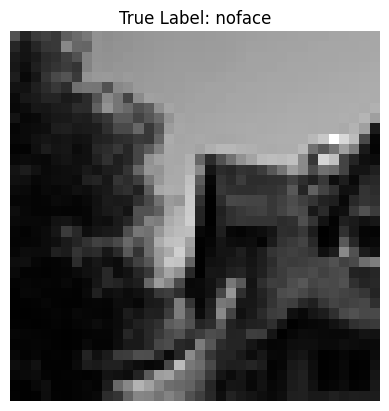

Predicted Label: noface


In [ ]:
import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt



import torch.nn as nn
import torch.nn.functional as F


import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # 50% Dropout
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x



# Directories
train_dir = '/content/drive/MyDrive/machine_learning_pro/deep_learning_project/train_images'
test_dir = '/content/drive/MyDrive/machine_learning_pro/deep_learning_project/test_images'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# datasets
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

# Validation set size and batch size
valid_size = 0.2
batch_size = 32

# rain/validation sets
num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:], indices_train[:split_tv]

train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)

# Classes for visualization
classes = ('noface', 'face')

# Checking GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model, loss function, and optimizer
model = Net().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        # Compute loss and backpropagation
        loss = loss_fn(outputs, labels)
        loss.backward()

        #  weights Update
        optimizer.step()

        # Logging
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100
            print(f'Batch {i+1} Loss: {last_loss}')
            tb_x = epoch_index * len(train_loader) + i + 1
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    return running_loss / len(train_loader)

# Test function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Training loop
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'/content/drive/MyDrive/machine_learning_pro/runs/sauveguardes_{timestamp}')
epoch_number = 0

EPOCHS = 8
best_vloss = float('inf')
previous_model_path = None


for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}:')
    # Training
    model.train()
    avg_loss = train_one_epoch(epoch, writer)
    # Validation
    model.eval()
    running_vloss = 0.0
    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / len(valid_loader)
    print(f'LOSS train {avg_loss:.4f} valid {avg_vloss:.4f}')

    #  metrics
    writer.add_scalars('Training vs. Validation Loss', {'Training': avg_loss, 'Validation': avg_vloss}, epoch + 1)
    writer.flush()

    # Saving the best model
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'/content/drive/MyDrive/machine_learning_pro/saved_models/model_{timestamp}_epoch_{epoch}.pth'

        if previous_model_path is not None and os.path.exists(previous_model_path):
            os.remove(previous_model_path)

    torch.save(model.state_dict(), model_path)

    previous_model_path = model_path

    epoch_number += 1

# Loading the model
print("Testing the model on test data...")
model.load_state_dict(torch.load(model_path))
test_accuracy = test_model(model, test_loader)

# The accuracy
writer.add_scalar('Accuracy/test', test_accuracy)
writer.close()




def test_single_image(model, test_dataset, index):

    image, true_label = test_dataset[index]

    # affichage of the image
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True Label: {classes[true_label]}")
    plt.axis('off')
    plt.show()

    model.eval()
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output, 1)

    print(f"Predicted Label: {classes[predicted_label.item()]}")

print("Testing the model on a single image...")
test_single_image(model, test_data, index=0)

<ipython-input-11-71a44a62ba0e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Le résultat de la détection est : face
Nombre de visages trouvés : 15


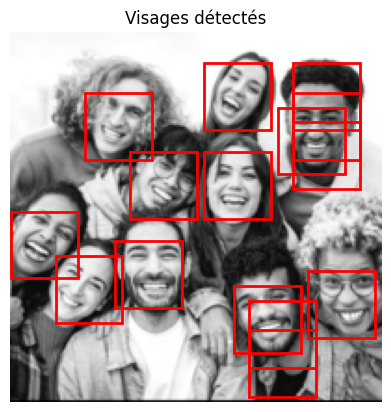

In [ ]:
model_path = '/content/drive/MyDrive/machine_learning_pro/saved_models/model_20250112_175529_epoch_6.pth'
model.load_state_dict(torch.load(model_path))
classes = ('noface', 'face')


def charger_image(image_path):
    image = Image.open(image_path).convert('L')
    transform = transforms.ToTensor()
    image_tensor = transform(image)
    return image_tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Fonction pour découper l'image en fenêtres
def decouper_image_en_fenetres(image, taille_fenetre=36, stride=6):
    if isinstance(image, torch.Tensor):
        image = image.squeeze(0)  # Supprimer la dimension des canaux si présente

    H, W = image.shape
    fenetres = []
    positions = []

    for i in range(0, H - taille_fenetre + 1, stride):
        for j in range(0, W - taille_fenetre + 1, stride):
            fenetre = image[i:i + taille_fenetre, j:j + taille_fenetre]
            fenetres.append(fenetre)
            positions.append((j, i, taille_fenetre, taille_fenetre))  # (x, y, w, h)

    return fenetres, positions

# Suppression des doublons avec NMS
def non_maximum_suppression(predictions, scores, threshold=0.5):
    if len(predictions) == 0:
        return []

    boxes = np.array(predictions)
    scores = np.array(scores)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]  # Trier par score décroissant

    keep = []

    while len(order) > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        inter = np.maximum(0, xx2 - xx1) * np.maximum(0, yy2 - yy1)
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        indices = np.where(iou <= threshold)[0]
        order = order[indices + 1]

    return [predictions[i] for i in keep]

# Fonction pour tester une image
def test_image_pour_face(model, image, classes, device, taille_fenetre=36, stride=8, seuil_confiance=0.8):
    fenetres, positions = decouper_image_en_fenetres(image, taille_fenetre, stride)

    model.eval()
    predictions = []
    scores = []
    faces_detectees = []

    with torch.no_grad():
        for idx, fenetre in enumerate(fenetres):
            fenetre = fenetre.unsqueeze(0).unsqueeze(0).to(device)
            output = model(fenetre)
            confidence, predicted_label = torch.max(output, 1)

            if predicted_label.item() == 1 and confidence.item() > seuil_confiance:
                predictions.append(positions[idx])
                scores.append(confidence.item())

    # Appliquer NMS pour supprimer les doublons
    final_faces = non_maximum_suppression(predictions, scores, threshold=0.5)
    return 'face' if len(final_faces) > 0 else 'noface', len(final_faces), final_faces

# Charger une image
def charger_image(image_path):
    image = Image.open(image_path).convert('L')  # Convertir en niveaux de gris
    transform = transforms.ToTensor()
    image_tensor = transform(image)
    return image_tensor

# Chemin vers l'image
image_path = "/content/drive/MyDrive/machine_learning_pro/people.png"
image = charger_image(image_path).to(device)

# image = image_tensor.to(device)
# Détection des visages
resultat, faces_trouvees, final_faces = test_image_pour_face(model, image, classes, device)

# Résultats
print(f"Le résultat de la détection est : {resultat}")
print(f"Nombre de visages trouvés : {faces_trouvees}")

# Afficher l'image avec les visages détectés
if faces_trouvees > 0:
    image_np = image.cpu().squeeze(0).numpy()
    plt.imshow(image_np, cmap='gray')
    for (x, y, w, h) in final_faces:
        rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
        plt.gca().add_patch(rect)
    plt.title("Visages détectés")
    plt.axis('off')
    plt.show()

<ipython-input-26-2feb1a76681e>:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


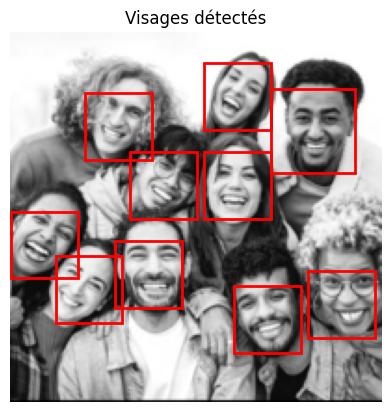

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn




class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # 50% Dropout
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
# Chargeement de l'image
def charger_image(image_path):
    image = Image.open(image_path).convert('L')
    transform = transforms.ToTensor()
    return transform(image)

# L'image pour en echelles
def redimensionner_image(image, scale):
    largeur, hauteur = image.size
    nouvelle_largeur = int(largeur * scale)
    nouvelle_hauteur = int(hauteur * scale)
    return image.resize((nouvelle_largeur, nouvelle_hauteur), Image.Resampling.LANCZOS)

# Découpage de l'image en fenetres glissantes
def decouper_image_en_fenetres(image, taille_fenetre=36, stride=8):
    H, W = image.shape
    fenetres = []
    positions = []

    for i in range(0, H - taille_fenetre + 1, stride):
        for j in range(0, W - taille_fenetre + 1, stride):
            fenetre = image[i:i + taille_fenetre, j:j + taille_fenetre]
            fenetres.append(fenetre)
            positions.append((j, i, taille_fenetre, taille_fenetre))  # (x, y, largeur, hauteur)

    return fenetres, positions

# Calcul de l'Intersection over Union (IoU)
def calculer_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    union = (box1[2] * box1[3]) + (box2[2] * box2[3]) - intersection
    return intersection / union if union > 0 else 0

# Non-Maximum Suppression (NMS)
def non_maximum_suppression(boxes, scores, iou_threshold=0.1, conf_threshold=0.85):

    if len(boxes) == 0:
        return []

    # Les boites en numpy
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Filtrage des boîtes en fonction du seuil de confiance
    keep_indices = scores > conf_threshold
    boxes = boxes[keep_indices]
    scores = scores[keep_indices]

    # Si aucune boite ne reste apres filtrage
    if len(boxes) == 0:
        return []

    # Calcul des coordonnees des boites
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    # Calcul des aires des boîtes
    areas = (x2 - x1) * (y2 - y1)

    # Trie par score predictions decroissant
    order = scores.argsort()[::-1]

    keep = []

    while len(order) > 0:
        i = order[0]  # La boîte avec le plus grand score
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        inter = np.maximum(0, xx2 - xx1) * np.maximum(0, yy2 - yy1)
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        # Les indices où l'IoU est inférieur au seuil
        indices = np.where(iou <= iou_threshold)[0]
        order = order[indices + 1]

    # Boîtes sélectionnées
    return [boxes[i] for i in keep]




# Détection de visages dans une image
def detecter_visages(model, image, device, echelles=[1.0, 0.8, 0.6], taille_fenetre=36, stride=8, seuil_confiance=0.8):
    model.eval()
    detections = []
    scores = []

    for echelle in echelles:
        image_redimensionnee = redimensionner_image(image, echelle)
        image_tensor = transforms.ToTensor()(image_redimensionnee).squeeze(0)

        fenetres, positions = decouper_image_en_fenetres(image_tensor.numpy(), taille_fenetre, stride)

        with torch.no_grad():
            for idx, fenetre in enumerate(fenetres):
                fenetre = torch.tensor(fenetre).unsqueeze(0).unsqueeze(0).to(device)
                output = model(fenetre)
                confidence, predicted_label = torch.max(output, 1)

                if predicted_label.item() == 1 and confidence.item() > seuil_confiance:
                    x, y, w, h = positions[idx]
                    detections.append((int(x / echelle), int(y / echelle), int(w / echelle), int(h / echelle)))
                    scores.append(confidence.item())

    # Eliminons les doublons
    final_faces = non_maximum_suppression(detections, scores)
    return final_faces

# Affichons des résultats
def afficher_resultats(image_path, faces):
    image = Image.open(image_path).convert('L')
    plt.imshow(image, cmap='gray')

    for (x, y, w, h) in faces:
        rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
        plt.gca().add_patch(rect)

    plt.title("Visages détectés")
    plt.axis('off')
    plt.show()

# Charger le modèle
model_path = '/content/drive/MyDrive/machine_learning_pro/saved_models/model_20250112_175529_epoch_6.pth'
model.load_state_dict(torch.load(model_path))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Détection des visages dans l'image
image_path = "/content/drive/MyDrive/machine_learning_pro/people.png"
image = Image.open(image_path).convert('L')
faces = detecter_visages(model, image, device)

# Afficher les résultats
afficher_resultats(image_path, faces)
